## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Poni](#poni)
* [Integration](#integration)

## TODO

- mettre un rot1 static a 0.5 degrees dans la fonction de fit -> voir si on arrive a calibrer.
- calibration et mesures sont faites a des positions de gamma differentes.
- Il faut donc propager le poni en prenant cela en compte.
- Il faut donc extraire le gamma en plus du delta.
- Il ne faut pas oublier de prendre en compte aussi les offsets des angles delta et gamma.

## Calibration <a name="calibration"></a>

This tutorial is for the calibration of an Xpad_flat on the Soleil Diffabs Diffractometer.

The calibration data is a scan on the delta motor with a CeO2 calibrant.

In [1]:
%matplotlib notebook

# first the imports
from typing import Callable, Iterator, List, NamedTuple, Optional, Text, Tuple

import os
import functools
import time

from collections import namedtuple
from math import pi

import numpy
import pylab
import pyFAI

import ipywidgets as widgets

from h5py import Dataset, File
from IPython.display import display
from numpy import ndarray
from pyFAI.detectors import detector_factory
from pyFAI.gui import jupyter

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    calibration, get_dataset, integrate, save_as_edf

In [2]:
# calibration path
ROOT_CALIBRATION = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20151386", "2016", "Run2")

# data path
ROOT = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "99160066")
PUBLISHED = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "99160066", "published-data")

In [23]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.
# TODO ajout du mask pour la calibration

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = Length(3.606099e-01)
poni1 = Length(1.314413e-01)
poni2 = Length(3.610775e-02)
rot1 = 3.85e-3  # convert degree to radian
rot2_scale = 1  # convert degree to radian
rot2_offset = Angle(18.33)  # radian
rot3 = Angle(7.19961198098e-07)

functions = (
    CalibrationFunctions("dist", "poni1", "poni2",
                         "rot1",
                         "pi*(rot2_scale * delta + rot2_offset)/180",
                         "rot3"),
    [Parameter[Length]("dist", distance, (distance-0.01, distance+0.01)),
     Parameter[Length]("poni1", poni1, (poni1-0.1, poni1+0.1)),
     Parameter[Length]("poni2", poni2, (poni2-0.1, poni2+0.1)),
     Parameter[Angle]("rot1", rot1, (rot1, rot1)),
     Parameter[float]("rot2_scale", rot2_scale, (rot2_scale, rot2_scale)),
     Parameter[Angle]("rot2_offset", rot2_offset, (rot2_offset-0.5, rot2_offset+0.5)),
     Parameter[Angle]("rot3", rot3, (rot3-0.1, rot3+0.1))]
)

def to_use(frame: CalibrationFrame) -> bool:
    return True if frame.idx in range(13) else False

params = Calibration(os.path.join(PUBLISHED, "xrd", "calibration"),
                     os.path.join(ROOT_CALIBRATION, "2016-03-23", "XRD18keV_26.nxs"),
                     DatasetPathWithAttribute("interpretation", b"image"),
                     DatasetPathContains("scan_data/actuator_1_1"),
                     [0, 3, 6, 9],
                     to_use,
                     Calibrant("CeO2"),
                     Detector("Xpad_flat"),
                     Wavelength(6.8877e-11),
                     functions
                    )

In [19]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [20]:
silx = my_cmd_button("silx view --use-opengl-plot " + params.filename,
                     'Silx View ' + os.path.basename(params.filename))

In [21]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

cmds = save_as_edf(params)
for cmd, idx in zip(cmds, params.idxs):
    my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(params.filename) + " " + str(idx))

Gtk-Message: Failed to load module "canberra-gtk-module"
  File "/usr/lib/python2.7/dist-packages/silx/gui/plot/PlotActions.py", line 38, in <module>
    since_version='0.6')
CeO2 Calibrant with 41 reflections 
CeO2 Calibrant with 41 reflections 
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0177120175331
            Iterations: 59
            Function evaluations: 529
            Gradient evaluations: 59
INFO:pyFAI.geometryRefinement:Constrained Least square 0.0189171727517 --> 6.04505717854e-05
INFO:pyFAI.geometryRefinement:maxdelta on rot1: 0.0 --> -1.37230867062 
INFO:pyFAI.massif:Image size is (960, 560)
INFO:pyFAI.massif:Binning size is [1, 1]
INFO:pyFAI.massif:Labeling found 11108 massifs.
INFO:pyFAI.massif:Labeling found 11108 massifs.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0177120175331
            Iterations: 59
            Function evaluations: 529
            Gradient evalua

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.606311e-01m	PONI= 1.314052e-01, 3.615871e-02m	rot1=0.003850  rot2= 0.083690  rot3= -0.000000 rad
DirectBeamDist= 361.900mm	Center: x=267.462, y=1243.518 pix	Tilt=4.800 deg  tiltPlanRotation= 92.628 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.681912e-01m	PONI= 1.311321e-01, 3.376145e-02m	rot1=-0.002289  rot2= 0.142821  rot3= -0.000007 rad
DirectBeamDist= 371.979mm	Center: x=266.185, y=1415.984 pix	Tilt=8.184 deg  tiltPlanRotation= 89.088 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.887700e-11m
SampleDetDist= 3.573590e-01m	PONI= 1.372483e-01, 3.642274e-02m	rot1=0.004160  rot2= 0.169709  rot3= 0.000000 rad
DirectBeamDist= 362.571mm	Center: x=268.740, y=1526.807 pix	Tilt=9.727 deg  tiltPlanRotation= 91.391 deg
Detector Xpad

<IPython.core.display.Javascript object>


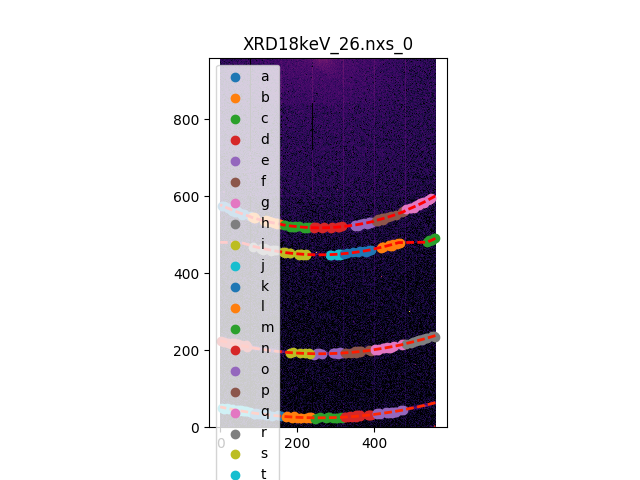

<IPython.core.display.Javascript object>


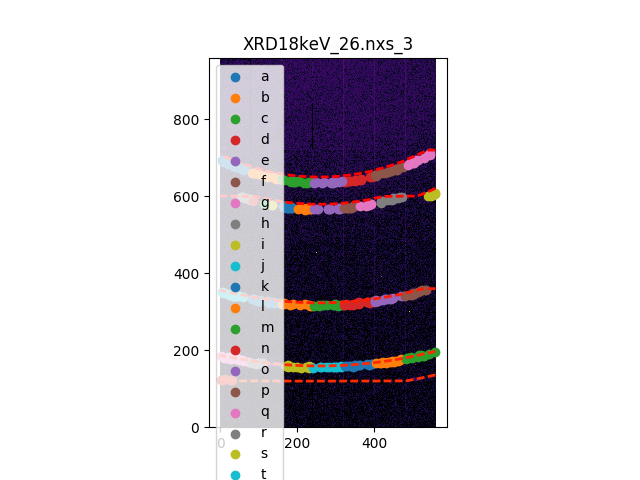

<IPython.core.display.Javascript object>


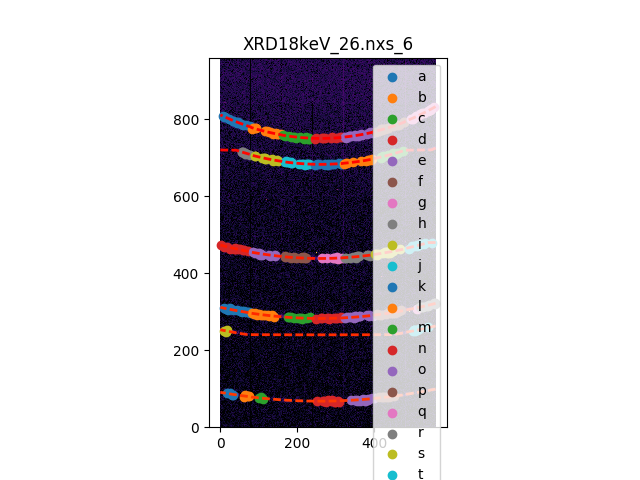

<IPython.core.display.Javascript object>


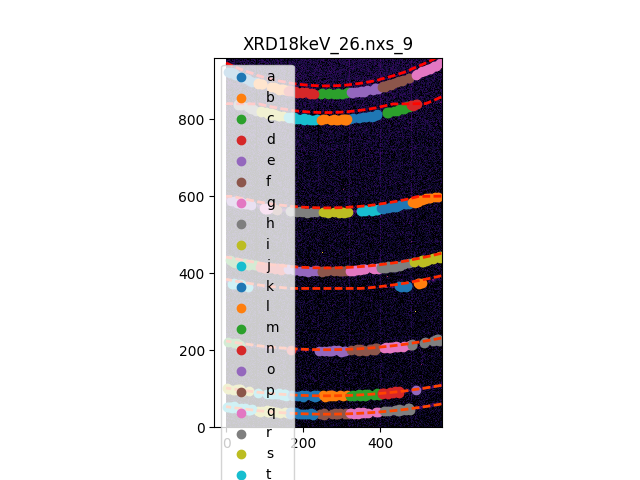

Cost function before refinement: 6.06031538584e-05
[  3.60609900e-01   1.31441300e-01   3.61077500e-02   3.85000000e-03
   1.00000000e+00   1.83300000e+01   7.19961198e-07]
     fun: 2.4301221294965573e-07
     jac: array([ -6.68751916e-08,  -2.02618576e-06,   4.79046317e-07,
        -2.84930387e-07,  -1.57133846e-06,   2.11131699e-08,
        -8.17124146e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([  3.58800104e-01,   1.34082115e-01,   3.62827601e-02,
         3.85000000e-03,   1.00000000e+00,   1.83300203e+01,
         7.19962619e-07])
Cost function after refinement: 2.4301221295e-07
GonioParam(dist=0.35880010410964802, poni1=0.13408211457171257, poni2=0.036282760096331565, rot1=0.0038500000000000001, rot2_scale=1.0, rot2_offset=18.330020340031989, rot3=7.1996261877085389e-07)
maxdelta on: poni1 (1) 0.1314413 --> 0.134082114572


XRD18keV_26.nxs_1
ControlPoints instance conta

<IPython.core.display.Javascript object>


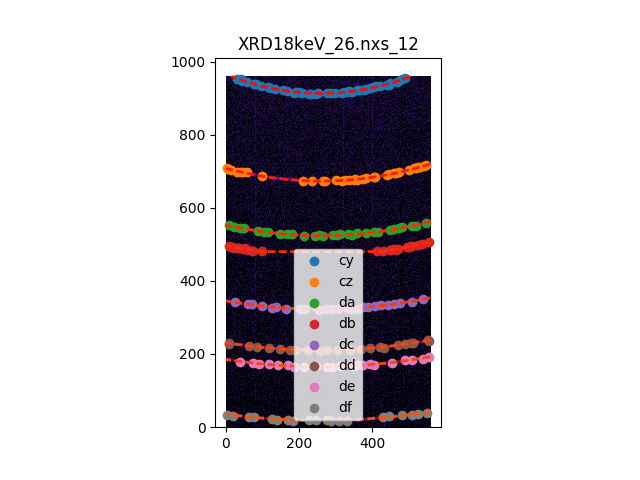

<IPython.core.display.Javascript object>


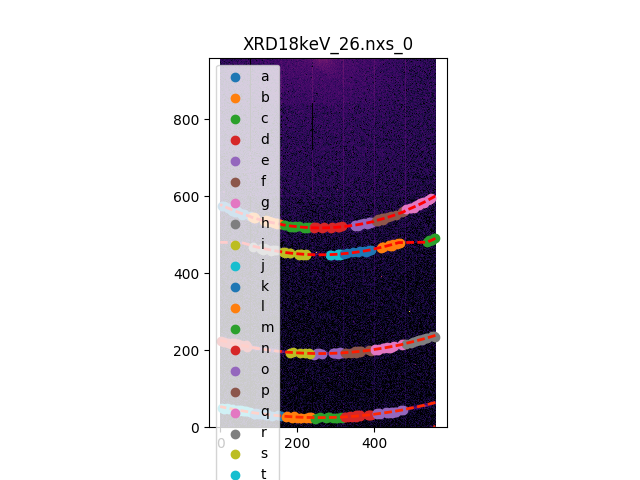

<IPython.core.display.Javascript object>


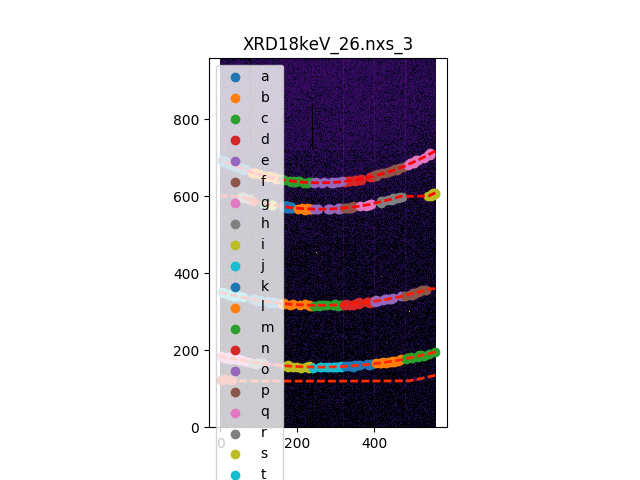

<IPython.core.display.Javascript object>


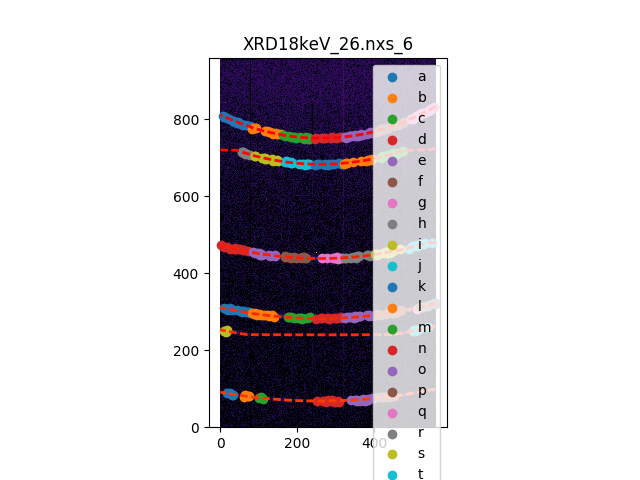

<IPython.core.display.Javascript object>


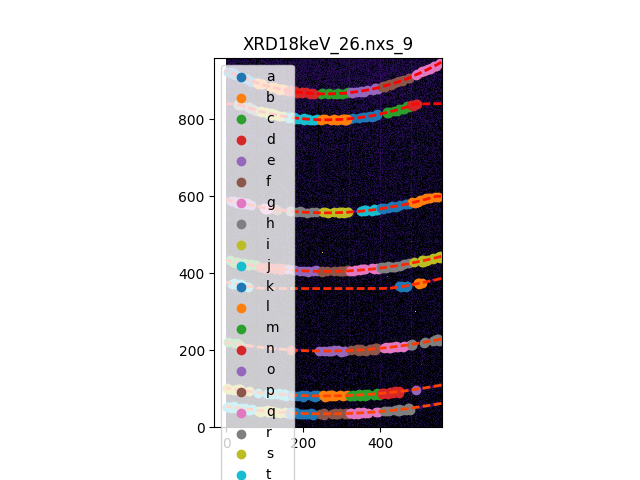

<IPython.core.display.Javascript object>


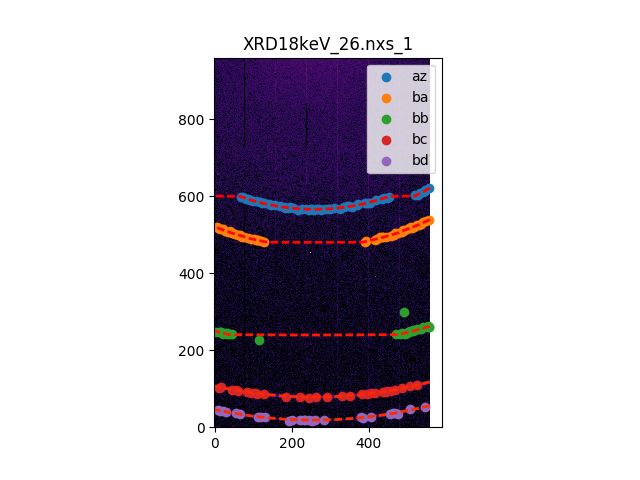

<IPython.core.display.Javascript object>


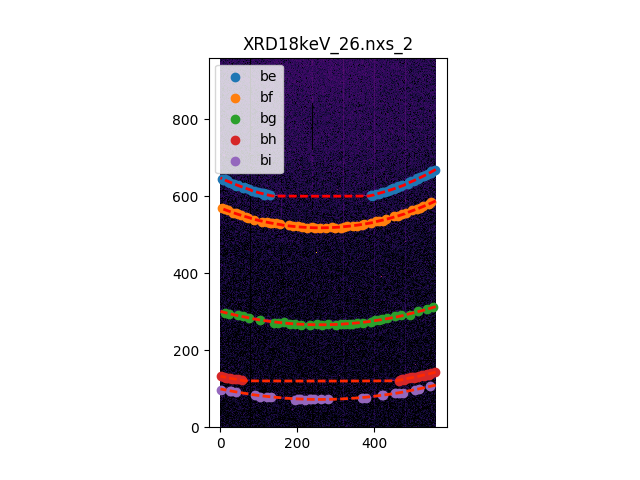

<IPython.core.display.Javascript object>


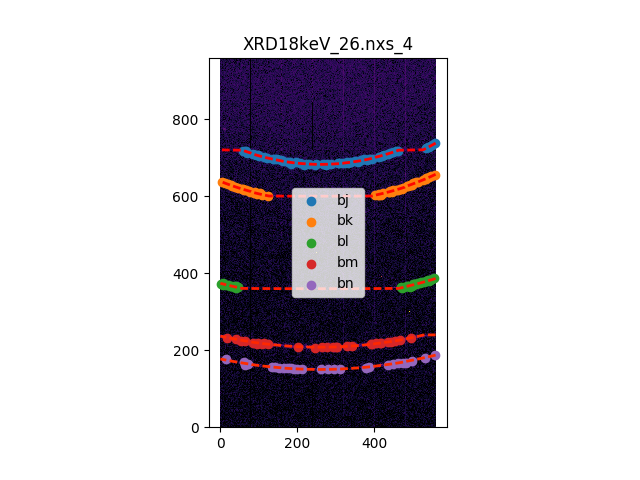

<IPython.core.display.Javascript object>


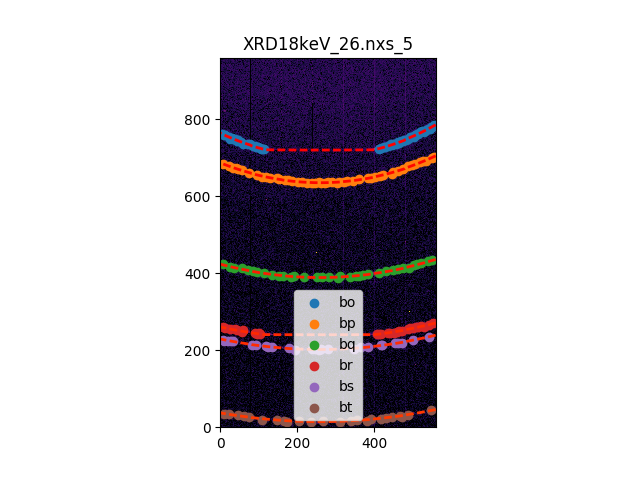

<IPython.core.display.Javascript object>


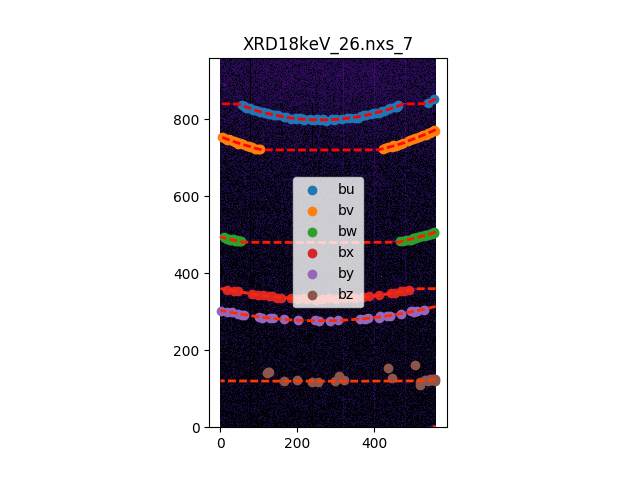

<IPython.core.display.Javascript object>


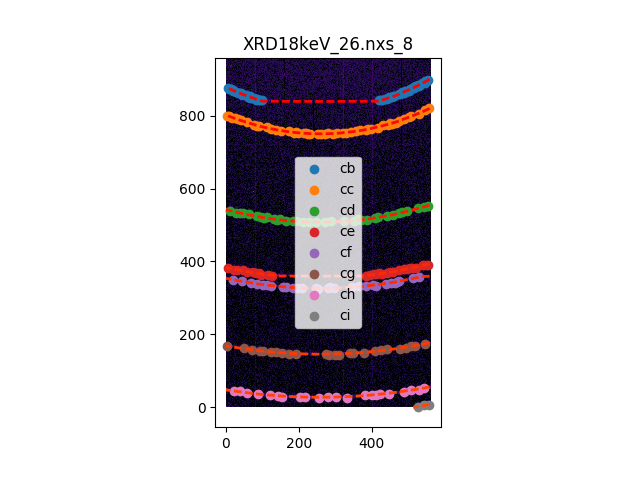

<IPython.core.display.Javascript object>


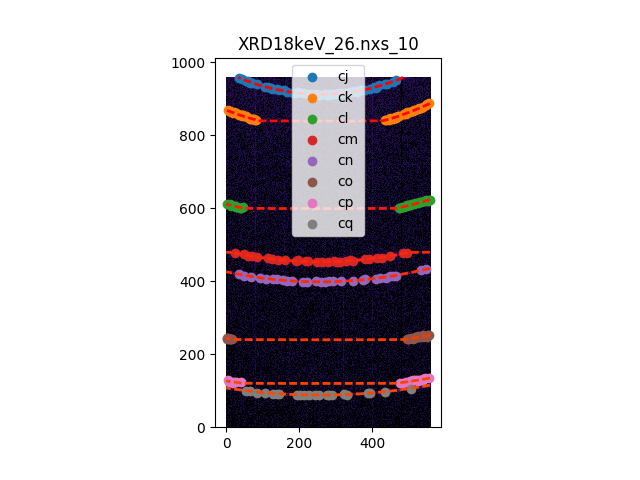

<IPython.core.display.Javascript object>


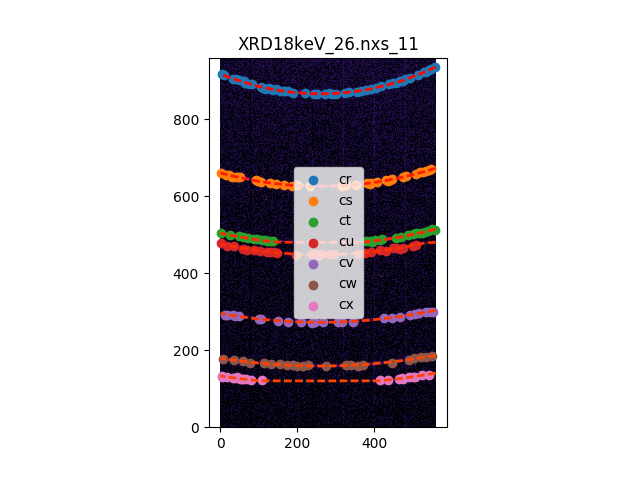

<IPython.core.display.Javascript object>


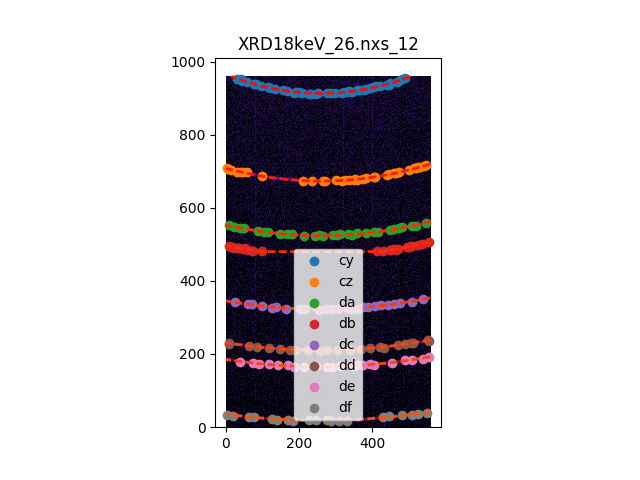

In [24]:
# execute the calibration

calibration(json, params)

<IPython.core.display.Javascript object>


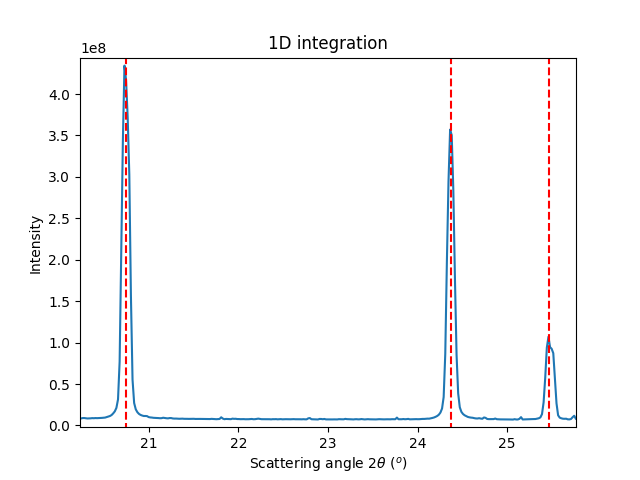

In [25]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 3000, 0, img)
    return img

integrate(json, params, f, plot_calibrant=True)

## Generate Poni for a given delta position  <a name="poni"></a>

In [26]:
# generic objects used for the tomographie integration

TomoSources = NamedTuple('TomoSources', [('filename', Text),
                                         ('images_path', DatasetPath),
                                         ('rotations_path', DatasetPath),
                                         ('translations_path', DatasetPath),
                                         ('delta_path', DatasetPath)])

TomoFrame = NamedTuple('TomoFrame', [("image", ndarray),
                                     ("shape", Tuple[int, int]),
                                     ("index", Tuple[int, int]),
                                     ("rotation", float),
                                     ("translation", float),
                                     ("delta", float)])

def read_multi(params: TomoSources) -> Iterator[TomoFrame]:
    """
    :param sources: list des fichiers à traiter.
    :type sources: list(str)

    :return: yield frames of data contain in all NxEntries located at the data_path location.
    :rtype: Frame
    """
    with File(params.filename, mode='r') as f:
        images = get_dataset(f, params.images_path)
        rotations = get_dataset(f, params.rotations_path)
        translations = get_dataset(f, params.translations_path)
        delta = get_dataset(f, params.delta_path)[0]
        shape = images.shape[0], images.shape[1]
        for rotation_idx, rotation in enumerate(rotations):
            for translation_idx, translation in enumerate(translations):
                yield TomoFrame(images[rotation_idx, translation_idx,:],
                                shape,
                                (rotation_idx, translation_idx),
                                rotation, translation, delta)

In [27]:
def save_poni(json: str,
              params: TomoSources) -> None:
    gonio = pyFAI.goniometer.Goniometer.sload(json)

    poni = None
    for tomoframe in read_multi(params):
        ai = gonio.get_ai(tomoframe.delta)
        basedir = os.path.splitext(os.path.basename(sample.filename))[0]
        directory = os.path.join(PUBLISHED, "xrd", basedir)
        try:
            os.makedirs(directory)
        except OSError:
            pass
        poni = os.path.join(directory, basedir + '.poni')
        ai.save(poni)
        break
    return poni

In [28]:
sample  = TomoSources(os.path.join(ROOT, "2016", "Run2", "2016-03-27", "P14_13_57.nxs"),
                      DatasetPathWithAttribute("interpretation", b"image"),
                      DatasetPathContains("scan_data/trajectory_2_1"),
                      DatasetPathContains("scan_data/trajectory_1_1"),
                      DatasetPathContains("D13-1-CX1__EX__DIF.1-DELTA__#1/raw_value"))

In [29]:
sampleButton = my_cmd_button("silx view --use-opengl-plot " + sample.filename,
                             'Silx View ' + os.path.basename(sample.filename))

In [30]:
PONI = save_poni(json, sample)

## Dark and Mask

In [31]:
# Compute the mask and the dark
# 3.5 could be simplify with 3.6

DarkMaskSources = NamedTuple('DarkMaskSources', [('filenames', List[Text]),  # name of the files
                                                 ('threshold', int),  # mask all pixel above this treshold
                                                 ('detector', Optional[Text]),
                                                 ('images_path', DatasetPath)])


def create_dark_and_mask(params: DarkMaskSources) -> Tuple[ndarray, ndarray]:
    """
    génère un dark moyen ainsi qu'un mask avec les dark mesurés. Sur
    un XPAD, le dark doit valoir zero (si le détecteur est bien
    calibré). Nous utilisons tous les pixels dont la valeur est
    supérieur à 2 pour définir un masque (mask ;). Pour la prochaine
    expérience penser à faire non pas un seul dark mais des séries de
    dark.
    """
    for i, filename in enumerate(params.filenames):
        with File(filename, mode='r') as f:
            img = get_dataset(f, params.images_path)[0]  # read the first image
            _mask = numpy.where(img > params.threshold, True, False)
            if i == 0:
                dark = img.copy()
                mask = _mask.copy()
            else:
                dark += img
                mask = numpy.logical_or(mask, _mask)

    if params.detector is not None:
        det = detector_factory(params.detector)
        mask = numpy.logical_or(mask, det.calc_mask())
        # on a repere des discidents
        mask[480:482, 480:482] = True

    dark = dark.astype(float)
    dark /= len(params.filenames)
    dark = dark.astype('uint32')

    return dark, mask


t0 = time.time()
dark, mask = create_dark_and_mask(DarkMaskSources([os.path.join(ROOT, "2016", "Run2", "2016-03-26", "dark_%d.nxs" % n) for n in range(7, 12)],
                                  1, 'Xpad_flat',
                                  DatasetPathWithAttribute("interpretation", b"image")))
print("dark and mask time: ", time.time() - t0)

dark and mask time:  0.528571605682373


## Flat

In [32]:
# compute the flat

FlatParams = NamedTuple('FlatParams', [('filename', Text),  # name of the file
                                       ('threshold', float),  # mask all pixel above this treshold
                                       ('dark', Optional[ndarray]),
                                       ('images_path', DatasetPath)])

def get_flat(params: FlatParams) -> ndarray:
    """
    :param filename: name of the files
    :type filename: list(str)

    génère un flat corrigé du dark si dark is not None
    """
    with File(params.filename, mode='r') as f:
        images = get_dataset(f, params.images_path)[:]
        flat = images.mean(axis=0)
        if dark is not None:
            flat -= dark

        flat = numpy.where(numpy.abs(flat) <= params.threshold, params.threshold, flat)

        return flat

t0 = time.time()
flat = get_flat(FlatParams(os.path.join(ROOT, "2016", "Run2", "2016-03-26", "flat_12.nxs"),
                           1, dark,
                           DatasetPathWithAttribute("interpretation", b"image")))
print("flat time: ", time.time() - t0)

flat time:  0.12645816802978516


## Unfold 

In [33]:
UnfoldFrame = NamedTuple('UnfoldFrame', [("tomoframe", TomoFrame),
                                         ("unfolded", ndarray)])

Unfold = NamedTuple('Unfold', [('sources', TomoSources),  # sources of the data's
                               ('poni', Text),  # the poni file use to do the unfold
                               ('mask', Optional[ndarray]),  # name of the poni file used for the integration.
                               ('dark', Optional[ndarray]),  # mask used for the computation.
                               ('flat', Optional[ndarray]),  # number of bins used for the powder spectrum.
                               ('npt_rad', int),  # he number of bins used for the powder spectrum.
                               ('npt_azim', int),  # he number of bins used for the powder spectrum.
                              ])

def unfold(params: Unfold) -> Iterator[UnfoldFrame]:
    """
    :return: the tomography datas
    :rtype: numpy.ndarray

    the return data is a 5 dimensions numpy array (rotation,
    translation, 2, Nr, Na). the third dimension contain the x and y
    coordinates of the powder diffraction (0 for X and 1 for Y)
    """
    # load the Azimuthal Integration parameters
    ai = pyFAI.load(params.poni)

    for tomoframe in read_multi(params.sources):
        data = tomoframe.image

        """ mask all the non counting pixels """
        # TODO comment optimiser ce calcul du mask dynamic qui prend vraiment du temps
        # we will use dummy value (0) in order to define the dynamic mask
        data[data>500] = 0

        unfolded, r, a = ai.integrate2d(data, params.npt_rad, params.npt_azim,
                                        filename=None, dark=dark, flat=flat, dummy=0)

        yield UnfoldFrame(tomoframe, unfolded)


def save_unfolded(filename: Text,
                  params: Unfold) -> str:
    with File(filename, mode="a") as f:
        # now fill with the values.
        for i, frame in enumerate(unfold(params)):
            if i == 0:
                # first create output volums at the right place
                group = f.require_group("tomography_unfolded")
                unfolded = group.require_dataset("unfolded", shape=frame.tomoframe.shape + (params.npt_azim, params.npt_rad),
                                                 dtype=frame.unfolded.dtype)
                rotation = group.require_dataset("rotation", shape=(frame.tomoframe.shape[0],),
                                                 dtype='float32')
                translation = group.require_dataset("translation", shape=(frame.tomoframe.shape[1],),
                                                    dtype='float32')        
                if params.dark is not None:
                    dark = group.require_dataset("dark", shape=params.dark.shape, dtype='uint32')
                    dark[:] = params.dark
                if params.flat is not None:
                    flat = group.require_dataset("flat", shape=params.flat.shape, dtype='uint32')
                    flat[:] = params.flat
                if params.mask is not None:
                    mask = group.require_dataset("mask", shape=params.mask.shape, dtype='uint32')
                    mask[:] = params.mask

            unfolded[frame.tomoframe.index[0], frame.tomoframe.index[1], :] = frame.unfolded
            rotation[frame.tomoframe.index[0]] = frame.tomoframe.rotation
            translation[frame.tomoframe.index[1]] = frame.tomoframe.translation
    return filename


t0 = time.time()
params = Unfold(sample, PONI, mask, dark, flat, 1000, 360)
unfolded = save_unfolded(os.path.join(PUBLISHED, "xrd", "P14_13_57", "P14_13_57_unfold.h5"),
                         params)
print("unfold time: ", time.time() - t0)

unfold time:  118.18085956573486


In [17]:
unfoldedButton = my_cmd_button("silx view --use-opengl-plot " + unfolded,
                     'Silx View ' + os.path.basename(unfolded))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
